# UJIIndoorLoc

In [1]:

import os


requirements_path = os.path.join(os.getcwd(), 'requirements.txt')

os.system(f'pip install -r {requirements_path}')
print("All dependencies have been installed.")

All dependencies have been installed.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#import sklearn measures




# 1. Read Data into Dataframe

In [3]:
datafolder = "../../datasets/UJIIndoorLoc"

trainfile = os.path.join(datafolder, "trainingData.csv")
validfile = os.path.join(datafolder, "validationData.csv")

#read data into pandas dataframes
train_data = pd.read_csv(trainfile)
test_data = pd.read_csv(validfile)
print("Training data shape:", train_data.shape)
test_data.head()




Training data shape: (19937, 529)


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774


## 1.2 Split Target and Feature

In [4]:
# Response variables in our problem are Building, Floor, Latitude, Longitude and Relative Position
train_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str).describe(include=['object'])
test_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str).describe(include=['object'])

## X and Y-data split
# Features are the WAP columns
X_train = train_data.iloc[:,:520]
X_test = test_data.iloc[:,:520]

# Select FLOOR and BUILDINGID for location prediction
y_train = train_data[['FLOOR', 'BUILDINGID', 'SPACEID']].copy()
y_test  = test_data[['FLOOR', 'BUILDINGID']].copy()
y_sID = y_train.copy()



#histogram of space ids for test set
# Combine BUILDINGID and FLOOR into a simpler location code
# Format: "B{BUILDING}F{FLOOR}" for better readability
y_sID['LOC_CODE'] = (y_sID['BUILDINGID'].astype(str) + 
                       y_sID['FLOOR'].astype(str)+
                       y_sID['SPACEID'].astype(str)
                       )
y_train['LOC_CODE'] = (y_train['BUILDINGID'].astype(str) + 
                       y_train['FLOOR'].astype(str)
                       )
y_test['LOC_CODE'] = (y_test['BUILDINGID'].astype(str) + 
                      y_test['FLOOR'].astype(str) 
                      )

# Keep only the combined column
y_train = y_train[['LOC_CODE']].astype('category')
y_test  = y_test[['LOC_CODE']].astype('category')
y_sID = y_sID[['LOC_CODE']].astype('category')



y_sID.shape,X_train.shape


((19937, 1), (19937, 520))

# Exploratory Data Analysis

drop NaN and show distribution

In [ ]:
X_raw_train = X_train
X_raw_test = X_test

# fill 100 with NaN for further processing
# Transform Train data
X_raw_train = (X_raw_train
			 .replace(to_replace=100,value=np.nan))
X_raw_test = (X_raw_test
			 .replace(to_replace=100,value=np.nan))


X_raw_combined = pd.concat([X_raw_train, X_raw_test], axis=0)
Y_raw_combined = pd.concat([y_train, y_test], axis=0)

# new train/test split from the combined dataset (used as overall "tot_split")
X_train_tot_split, X_test_tot_split, Y_train_tot_split, Y_test_tot_split = train_test_split(
	X_raw_combined, Y_raw_combined, test_size=0.2, random_state=42, stratify=Y_raw_combined
)

# create the train/validation split used elsewhere as "split_new"
# use the original training set and the location codes including SPACEID (y_train_new_predict)
X_train_split_sID, X_test_split_sID, Y_train_split_sID, Y_test_split_sID = train_test_split(
	X_train, y_sID, test_size=0.2, random_state=42, stratify=y_sID
)

# PCA on the split_new (for SPACEID experiments)
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_split_sID)
X_test_pca = pca.transform(X_test_split_sID)
print(f"Original number of features: {X_train_split_sID.shape[1]}")
print(type(X_train_pca))
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

# fill NaNs for algorithms that require no missing values
X_train_noNAN = X_train_split_sID.fillna(-110)
X_test_noNAN = X_test_split_sID.fillna(-110)

# convert PCA results back to DataFrame for consistency
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

# show shapes to verify consistency
X_raw_train.shape, X_raw_test.shape, X_train_split_sID.shape, X_test_split_sID.shape, Y_train_split_sID.shape, Y_test_split_sID.shape, X_train_pca.shape, X_test_pca.shape

Original number of features: 520
<class 'numpy.ndarray'>
Reduced number of features after PCA: 184


((19937, 520),
 (1111, 520),
 (15949, 520),
 (3988, 520),
 (15949, 1),
 (3988, 1),
 (15949, 184),
 (3988, 184))

### Initial Test Set

count    1111.000000
mean       16.475248
std         6.893728
min         1.000000
25%        11.000000
50%        15.000000
75%        21.000000
max        35.000000
dtype: float64

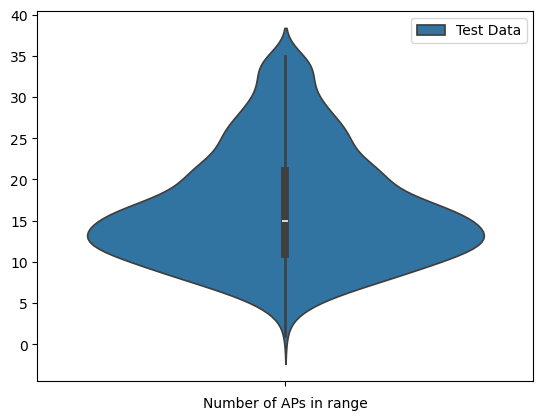

In [6]:
waps_in_range_train = (X_raw_train
                 .notnull()
                 .sum(axis = 1))

waps_in_range_test = (X_raw_test
                 .notnull()
                 .sum(axis = 1))

waps_in_range_tot_train_split = (X_train_tot_split
                 .notnull() 
                 .sum(axis = 1))
waps_in_range_tot_test_split = (X_test_tot_split
                 .notnull() 
                 .sum(axis = 1))

fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_test, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_test.describe()

### Initial Train Set

count    19937.000000
mean        17.994834
std          7.333575
min          0.000000
25%         13.000000
50%         17.000000
75%         22.000000
max         51.000000
dtype: float64

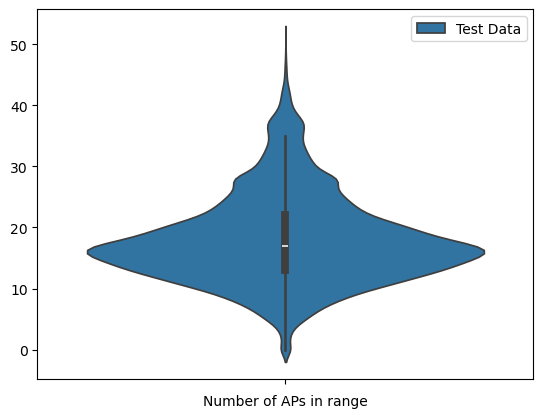

In [7]:
fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_train, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_train.describe()

### New Test Set

count    4210.000000
mean       17.854394
std         7.239640
min         0.000000
25%        13.000000
50%        17.000000
75%        22.000000
max        44.000000
dtype: float64

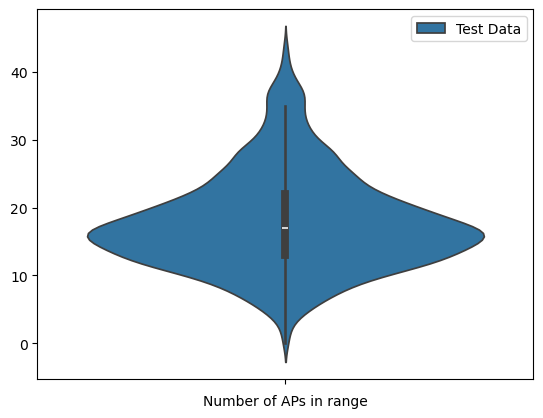

In [8]:
fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_tot_test_split, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_tot_test_split.describe()

### New Train Set

count    16838.000000
mean        17.929683
std          7.338540
min          0.000000
25%         13.000000
50%         17.000000
75%         22.000000
max         51.000000
dtype: float64

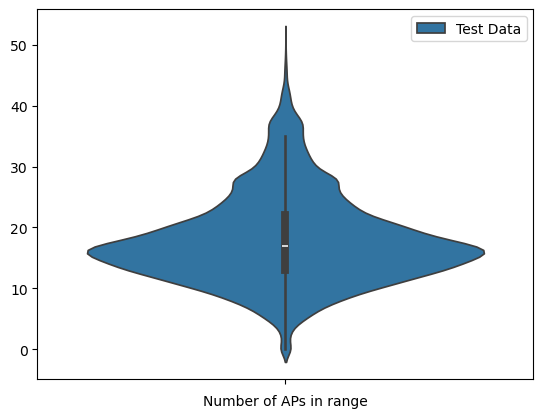

In [9]:
fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_tot_train_split, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_tot_train_split.describe()

### Initial not NaN-Values distribution 

count    358763.000000
mean        -78.497211
std          12.615758
min        -104.000000
25%         -88.000000
50%         -82.000000
75%         -72.000000
max           0.000000
dtype: float64

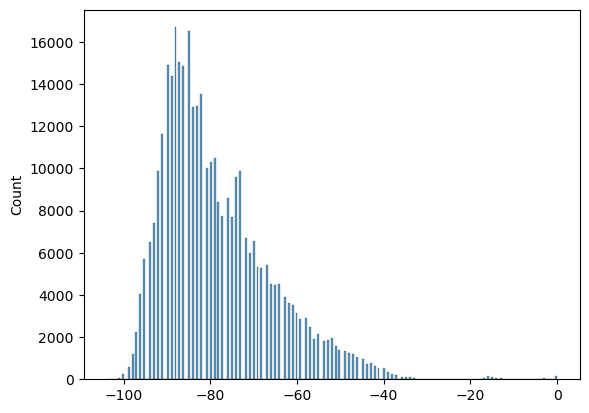

In [14]:
X_stack = X_raw_train.stack(future_stack=True)
sns.histplot(X_stack.dropna(),kde = False)
X_stack.describe()

## Feature scaling for KNN

c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


<Axes: ylabel='Count'>

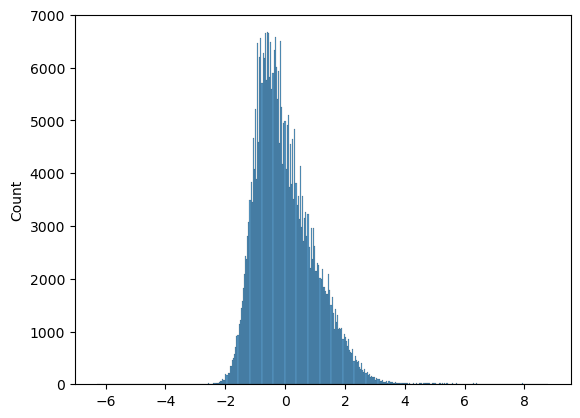

In [11]:

sc = StandardScaler()
X_std_train = sc.fit_transform(X_raw_train)
X_std_test = sc.transform(X_raw_test)

X_std_train = pd.DataFrame(X_std_train)
X_std_test = pd.DataFrame(X_std_test)

##plotting standardized data distribution
X_stack_std = X_std_train.stack(future_stack=True)
sns.histplot(X_stack_std.dropna(),kde = False)


## Do Preprocessing

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


def make_preprocessor(scale: bool = False):
    """
    Return a transformer that imputes missing WAPs to -110 and
    optionally applies StandardScaler to all columns.
    Use in Pipeline as: ('preprocessor', make_preprocessor(scale=...))
    """
    if scale:
        transformer = Pipeline([
            ("imp", SimpleImputer(strategy="constant", fill_value=-110)),
            ("scaler", StandardScaler())
        ])
    else:
        transformer = SimpleImputer(strategy="constant", fill_value=-110)

    # Apply to all columns; ColumnTransformer is a valid transformer for Pipeline
    return ColumnTransformer(
        [("all_waps", transformer, slice(None))],
        remainder="drop"
    )

## Random Forest can work with NaNs

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert categorical LOC_CODE to numeric codes
y_train_codes = y_train['LOC_CODE'].cat.codes
y_test_codes = y_test['LOC_CODE'].cat.codes
Y_train_tot_split_codes = Y_train_tot_split['LOC_CODE'].cat.codes
Y_test_tot_split_codes = Y_test_tot_split['LOC_CODE'].cat.codes

print(f"Number of unique locations: {y_train['LOC_CODE'].nunique()}")
print(f"Training samples: {len(y_train_codes)}, Test samples: {len(y_test_codes)}")

# =============================================================================
# Random Forest Classifier with Scaling
# =============================================================================
# clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
# clf.fit(X_std_train, y_train_codes)
# y_pred = clf.predict(X_std_test)
# accuracy = accuracy_score(y_test_codes, y_pred)
# print(f"\nAccuracy with Scaling: {accuracy:.4f}")

# =============================================================================
# Random Forest Classifier without Scaling (Original Split)
# =============================================================================
# clf_wo_scaling = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, criterion='entropy', max_features=None)
# clf_wo_scaling.fit(X_raw_train, y_train_codes)
# y_pred_wo_scaling = clf_wo_scaling.predict(X_raw_test)
# accuracy_wo_scaling = accuracy_score(y_test_codes, y_pred_wo_scaling)
# print(f"\nAccuracy without Scaling: {accuracy_wo_scaling:.4f}")
# classification_report_wo_scaling = classification_report(y_test_codes, y_pred_wo_scaling, target_names=y_train['LOC_CODE'].cat.categories)
# print("\nClassification Report without Scaling:")
# print(classification_report_wo_scaling)

# =============================================================================
# Random Forest Classifier without Scaling (New Train/Test Split)
# =============================================================================
# clf_woscaling_newsplit = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
# clf_woscaling_newsplit.fit(X_train_tot_split, Y_train_tot_split_codes)
# y_pred_woscaling_newsplit = clf_woscaling_newsplit.predict(X_test_tot_split)
# accuracy_woscaling_newsplit = accuracy_score(Y_test__tot_split_codes, y_pred_woscaling_newsplit)
# print(f"\nAccuracy with new train/test split: {accuracy_woscaling_newsplit:.4f}")

# =============================================================================
# Show Example Predictions
# =============================================================================
# comparison = pd.DataFrame({
#     'True': y_test['LOC_CODE'].values[:10],
#     'Predicted': y_train['LOC_CODE'].cat.categories[y_pred_wo_scaling[:10]]
# })
# print("\nFirst 10 predictions:")
# print(comparison)








Number of unique locations: 13
Training samples: 19937, Test samples: 1111


### Random Forest single Run with SpaceID und PCA

In [17]:
from sklearn.metrics import accuracy_score

# Train Random Forest on PCA features with SPACEID location codes
clf_woscaling_spaceid = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    n_jobs=-1, 
    max_features=None
)

# Fit on PCA-transformed training data
clf_woscaling_spaceid.fit(X_train_pca, Y_train_split_sID['LOC_CODE'].cat.codes)

# Predict on PCA-transformed test data
y_pred_woscaling_spaceid = clf_woscaling_spaceid.predict(X_test_pca)

# Evaluate accuracy
y_true_codes = Y_test_split_sID['LOC_CODE'].cat.codes
accuracy_woscaling_spaceid = accuracy_score(y_true_codes, y_pred_woscaling_spaceid)

print(f"\nRandom Forest Accuracy with SPACEID (PCA features): {accuracy_woscaling_spaceid:.4f}")
print(f"Number of unique SPACEID locations in training: {Y_train_split_sID['LOC_CODE'].nunique()}")
print(f"Number of unique SPACEID locations in test: {Y_test_split_sID['LOC_CODE'].nunique()}")


KeyboardInterrupt: 

## KNN-Classifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#get preprocessor function

X_preprocessor = make_preprocessor(scale=True)
X_std_train = X_preprocessor.fit_transform(X_train_split_sID)
X_std_test = X_preprocessor.transform(X_test_split_sID)




# Convert categorical LOC_CODE to numeric codes
y_train_codes = Y_train_split_sID['LOC_CODE'].cat.codes
y_test_codes = Y_test_split_sID['LOC_CODE'].cat.codes
# Train classifier
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(X_std_train, y_train_codes)

knn_clf_wo_scaling = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf_wo_scaling.fit(X_std_train, y_train_codes)
# Predict on test set
y_pred_knn = knn_clf.predict(X_std_test)
y_pred_knn_wo_scaling = knn_clf_wo_scaling.predict(X_std_test)
# Evaluate
accuracy_knn = accuracy_score(y_test_codes, y_pred_knn)
print(f"\nKNN Accuracy: {accuracy_knn:.4f}")
print("\nKNN Classification Report with Scaling:")
accuracy_knn_wo_scaling = accuracy_score(y_test_codes, y_pred_knn_wo_scaling)
print(f"\nKNN Accuracy without Scaling: {accuracy_knn_wo_scaling:.4f}")
print("\nKNN Classification Report without Scaling:")



classification_report_knn = classification_report(y_test_codes, y_pred_knn_wo_scaling, target_names=Y_train_split_sID['LOC_CODE'].cat.categories)
print(classification_report_knn)


KNN Accuracy: 0.6244

KNN Classification Report with Scaling:

KNN Accuracy without Scaling: 0.6244

KNN Classification Report without Scaling:


ValueError: Number of classes, 734, does not match size of target_names, 735. Try specifying the labels parameter

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# =================================================================================================================================================
# XGBoost with Scaling
# =============================================================================================================================
print("Training XGBoost with Scaling...")
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf_wo_scaling = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf_wo_scaling.fit(X_train_noNAN, y_train_codes)
y_pred_xgb_wo_scaling = xgb_clf_wo_scaling.predict(X_test_noNAN)
accuracy_xgb_wo_scaling = accuracy_score(y_test_codes, y_pred_xgb_wo_scaling)
print(f"\nXGBoost Accuracy without Scaling: {accuracy_xgb_wo_scaling:.4f}")

classification_report_xgb = classification_report(y_test_codes, y_pred_xgb_wo_scaling, target_names=y_train['LOC_CODE'].cat.categories)
print("\nXGBoost Classification Report without Scaling:")
print(classification_report_xgb)


XGBoost Accuracy: 0.8902

XGBoost Accuracy without Scaling: 0.8902

XGBoost Classification Report without Scaling:
              precision    recall  f1-score   support

          00       0.95      0.94      0.94        78
          01       0.97      0.91      0.94       208
          02       0.94      0.96      0.95       165
          03       0.99      0.96      0.98        85
          10       0.88      0.77      0.82        30
          11       0.97      0.62      0.76       143
          12       0.63      0.94      0.75        87
          13       0.73      0.87      0.80        47
          20       0.58      0.88      0.70        24
          21       0.94      0.97      0.96       111
          22       0.94      0.93      0.93        54
          23       0.87      1.00      0.93        40
          24       1.00      0.79      0.89        39

    accuracy                           0.89      1111
   macro avg       0.88      0.89      0.87      1111
weighted avg      

In [ ]:
# Silence noisy worker warnings
import os, warnings
warnings.filterwarnings("ignore", message=".pkg_resources is deprecated as an API.", category=UserWarning)
os.environ.setdefault("PYTHONWARNINGS", "ignore:pkg_resources is deprecated as an API:UserWarning")

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

from classifierConfigs import get_classifier_configs, get_scorings, model_requires_int_labels
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

##reload classifierConfigs
import importlib
import classifierConfigs as cc
importlib.reload(cc)

get_classifier_configs = cc.get_classifier_configs
get_scorings = cc.get_scorings
model_requires_int_labels = cc.model_requires_int_labels







# Use the train/validation split already computed earlier in the notebook
# (X_train_split_new, X_test_split_new, Y_train_split_new, Y_test_split_new)
# Ensure label Series are 1D and contain the LOC_CODE category


X_train = X_train_split_sID
X_val = X_test_split_sID
y_train = Y_train_split_sID['LOC_CODE'].astype('category')
y_val = Y_test_split_sID['LOC_CODE'].astype('category')

# Integer-coded labels for models that require them (e.g., some XGBoost multiclass setups)
y_train_int = y_train.cat.codes
y_val_int = y_val.cat.codes

# Task selection: 'multiclass' or 'binary'
task = 'multiclass'

# Multi-metric scoring and configs by task
scoring = get_scorings(multiclass=(task == 'multiclass'))
refit_metric = "f1_macro"
configs = get_classifier_configs(task=task)

results_dir = "artifacts/gridsearch"
os.makedirs(results_dir, exist_ok=True)
all_results = []

for name, cfg in configs.items():
    print(f"Running Grid Search for {name}...")
    scale_TF = name.lower().startswith('knn')  # Scale only for KNN
    pipe = Pipeline(steps=[
        ('preprocessor', make_preprocessor(scale=scale_TF)),
        ('classifier', cfg['model'])
    ])

    param_grid = {f'classifier__{k}': v for k, v in cfg['param_grid'].items()}

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        refit=refit_metric,
        n_jobs=2,
        verbose=3,
        cv=3
    )

    # Pick correct label vector for fitting: integer codes only if the model requires them
    y_fit = y_train_int if (task == 'multiclass' and model_requires_int_labels(name)) else y_train
    gs.fit(X_train, y_fit)

    # Save per-model CV results
    res_df = pd.DataFrame(gs.cv_results_)
    rank_col = f'rank_test_{refit_metric}' if f'rank_test_{refit_metric}' in res_df.columns else ('rank_test_score' if 'rank_test_score' in res_df.columns else None)
    if rank_col is not None:
        res_df = res_df.sort_values(rank_col)
    res_df.insert(0, 'model', name)
    res_df.insert(1, 'scoring', refit_metric)
    res_df['preproc_scaled'] = scale_TF
    out_path = os.path.join(results_dir, f"{name.replace(' ', '')}_cv_results{refit_metric}.csv")
    res_df.to_csv(out_path, index=False)
    all_results.append(res_df)

    print(f"Best parameters for {name}: {gs.best_params_} | Best {refit_metric}: {gs.best_score_:.4f}")

    # Predict on validation set and decode integer labels back to category names if needed
    y_val_pred = gs.predict(X_val)
    if task == 'multiclass' and model_requires_int_labels(name):
        # Map integer codes back to category labels using the training categories
        categories = y_train.cat.categories
        y_val_pred = pd.Series(y_val_pred).map(lambda c: categories[c] if (isinstance(c, (int, np.integer)) and c < len(categories)) else str(c)).values

    # Ensure y_val is plain array-like of labels (strings/categories) for reporting
    y_val_labels = y_val.values if hasattr(y_val, 'values') else y_val

    print(f"Validation Classification Report for {name}:\n")
    print(classification_report(y_val_labels, y_val_pred, zero_division=0))
    print("-" * 80)

if all_results:
    pd.concat(all_results, ignore_index=True).to_csv(
        os.path.join(results_dir, f"UJIIndoorLoc_ALL_cv_results_{refit_metric}.csv"),
        index=False
    )


Running Grid Search for XGBoost...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


ValueError: 
All the 144 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ~~~~~~~~~~~~~~~~~~~~~~~~^
        cloned_transformer,
        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
        params=step_params,
        ^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py", line 1001, in fit_transform
    result = self._call_func_on_transformers(
        X,
    ...<3 lines>...
        routed_params=routed_params,
    )
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py", line 910, in _call_func_on_transformers
    return Parallel(n_jobs=self.n_jobs)(jobs)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 77, in __call__
    return super().__call__(iterable_with_config)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\joblib\parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
                                                ~~~~^^^^^^^^
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\joblib\parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 139, in __call__
    return self.function(*args, **kwargs)
           ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\base.py", line 921, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ~~~~~~~~^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py", line 434, in fit
    X = self._validate_input(X, in_fit=True)
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py", line 412, in _validate_input
    raise ValueError(err_msg)
ValueError: fill_value=-110.0 (of type <class 'float'>) cannot be cast to the input data that is dtype('int64'). Make sure that both dtypes are of the same kind.
